In [2]:
# py -m poetry config virtualenvs.in-project true
# py -m poetry init -n
# py -m poetry add numpy matplotlib scipy pandas bokeh statsmodels
# py -m poetry add ipykernel
from typing import Optional
import pickle
import itertools
from pathlib import Path

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap


%load_ext autoreload
%autoreload 2

In [ ]:
THIS_PATH = Path.cwd()
TMP_PATH = THIS_PATH.joinpath("tmp")
TMP_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH = THIS_PATH.joinpath("results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
NORMAL_FONTSIZE = 20
RANDOM_SEED = 17
NP_SEED = 123

In [482]:

def model(x, b0, b1):
    # two-parameter model.
    return b1 * x + b0

def make_data():

    np.random.seed(NP_SEED)

    # Intercept
    b0 = 0

    # Slopes
    b1 = [-5, 5]

    # Noise
    sigma = 2

    # Sizes
    size1 = 125
    size2 = 135
    
    size = size1 + size2

    print("Total number of data points", size1 + size2)
    print(f"Weight cmp1: {size1 / size:.2f}" )
    print(f"Weight cmp2: {size2 / size:.2f}")

    # Predictor variable
    X1_1 = np.linspace(-2, 2, size1)
    # Simulate outcome variable--cluster 1
    Y1 = model(X1_1, b0, b1[0]) + np.random.normal(loc=0, scale=sigma, size=size1)

    # Predictor variable
    X1_2 = np.linspace(-3, 3, size2)
    # Simulate outcome variable --cluster 2
    Y2 = model(X1_2, b0, b1[1]) + np.random.normal(loc=0, scale=sigma, size=size2)

    return b0, b1, sigma, X1_1, X1_2, Y1, Y2


In [483]:
b0, b1, sigma, x1, x2, y1, y2 = make_data()

# joint data set with anonymous classes
x = np.append(x1, x2)
y = np.append(y1, y2)

Total number of data points 260
Weight cmp1: 0.48
Weight cmp2: 0.52


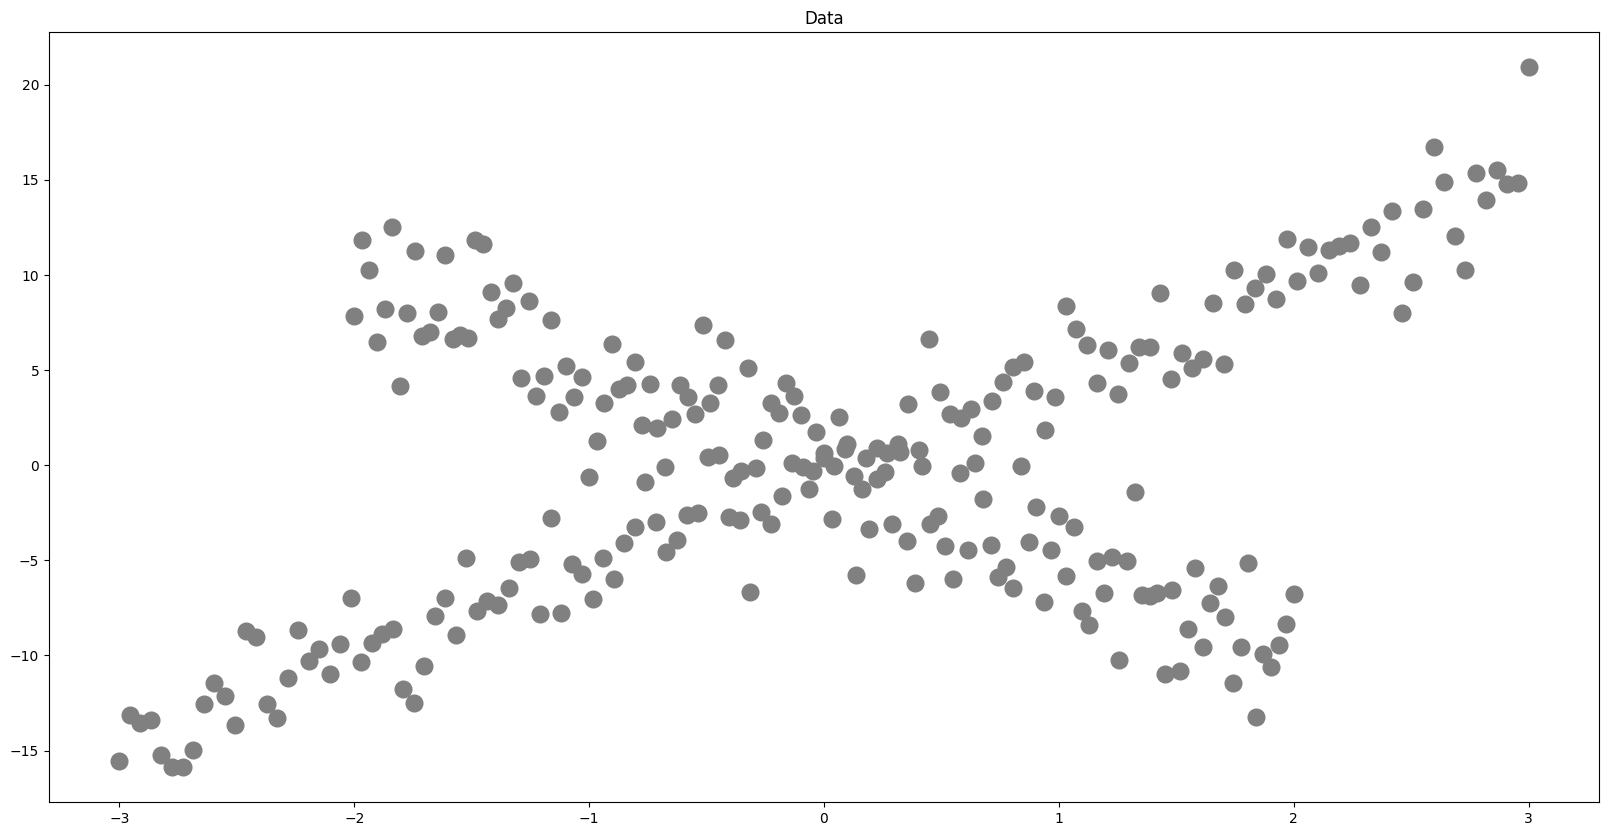

In [484]:
def plot_data(xs, ys):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_title("Data")
    for x, y in zip(xs, ys):
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color="gray",
        )
    plt.close()
    return fig

fig = plot_data((x1, x2), (y1, y2))
fig

In [485]:
def model(x, b0, b1):
    return b0 + b1 * x

def yerr_sq(x, y, *pars):
    return np.pow(model(x, *pars) - y, 2)

def get_log_likelihood(x, y, par):
    # # log likelihood for all data points
    # rss = np.sum(yerr_sq(x, y, *par))
    # # sigma_sq = rss / (len(y) - len(par))
    # sigma_sq = rss / len(y)

    # # log-likelihood
    # npoints = len(y)
    # ll = -0.5 * npoints * np.log(2 * np.pi * sigma_sq) - rss / (2 * sigma_sq)
    # return ll
    return np.sum(get_log_likelihoods(x, y, par))

def get_log_likelihoods(x, y, par):
    # log likelihood for each data point
    rss = yerr_sq(x, y, *par)
    # sigma_sq = np.sum(rss) / (len(y) - len(par))
    sigma_sq = np.sum(rss) / len(y)

    # https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood
    # log-likelihood for each point
    npoints = 1
    ll = -0.5 * npoints * np.log(2 * np.pi * sigma_sq) - rss / (2 * sigma_sq)
    return ll


def get_membership(x, y, pars):

    # RSS of all points for each model
    lls = np.exp(
        [get_log_likelihoods(x, y, par) for par in pars if par is not None]
    )

    p_membership = lls / np.sum(lls, axis=0)

    # For each datapoint get index of the line to which the datapoint is closest
    idxmodel = np.argmax(p_membership, axis=0)

    # if sigma_sq is not None:
    #     errsq = errsq / sigma_sq

    # For each datapoint get index of the line to which the datapoint is closest
    return idxmodel, p_membership

def split_data(x, y, pars):
    membership, _ = get_membership(x, y, pars)
    nmodels = len(pars)

    x_at_idxmod = []
    y_at_idxmod = []
    for idx_model in range(nmodels):
        mask = membership == idx_model
        x_at_idxmod.append(x[mask])
        y_at_idxmod.append(y[mask])
    
    return x_at_idxmod, y_at_idxmod


def _fit_lines(x, y, pars, sigma_sq=None):
    membership, _ = get_membership(x, y, pars)

    # With the memberships fit models
    nmodels = len(pars)
    popts = []
    rss_sum = 0.0
    for idx_model in range(nmodels):
        mask = membership == idx_model
        if pars[idx_model] is None or len(x[mask]) < len(pars[idx_model]):
            popts.append(None)
            return popts, np.inf
        popt, pcov, infodict, msg, ier = curve_fit(model, x[mask], y[mask], p0=pars[idx_model], full_output=True)
        if ier not in [1,2,3,4]:
            print(ier, msg)
        rss = np.sum(yerr_sq(x[mask], y[mask], *popt))
        rss_sum += rss
        # sigma_sq = rss / (len(x[mask]) - len(popt))
        popts.append(popt.tolist())

    return popts, rss_sum


def fit_lines(x, y, p0, nmax=50):
    popts, rss = _fit_lines(x, y, p0)
    # print(f"Initial: {rss} ({popts})")

    popts_min = popts
    rss_min = rss
    rss_prev = rss
    for i in range(nmax):
        popts, rss = _fit_lines(x, y, popts)
        if None in popts:
            break
        # print(f"Candidate ({i}): {rss_min} -> {rss} ({popts})")
        if rss < rss_min:
            # print(f"Update ({i}): {rss_min} -> {rss} ({popts})")
            popts_min = popts
            rss_min = rss
        elif rss == rss_prev:
            break
        rss_prev = rss
    
    print(f"Optimal: {rss_min} ({popts_min}) (nsteps={i})")
    return popts_min



In [496]:
m0_init = [0, 0]
m1_init = [0, 5]
m2_init = [0.1, 5]
m3_init = [0.1, -5]
m4_init = [0, -5]

p0 = [
    m0_init,
    m1_init,
    m2_init,
    m3_init,
    m4_init,
]

lls = []
bics = []
aics = []
pars_all_models = []
specificity_gain = []
for i in range(len(p0)):
    pars = fit_lines(x, y, p0[:i+1])

    xsplit, ysplit = split_data(x, y, pars)

    ll_tot = 0.0
    npar = 0
    for i, (_x, _y, _par) in enumerate(zip(xsplit, ysplit, pars)):
        # print(_y)
        if _par is None or len(_x) < len(_par) or _par is None:
            print(f"Data points in component {i+1} is ", len(_x))
            ll_tot = np.inf
            npar = np.inf
        else:
            # print(len(_y))
            ll = get_log_likelihood(_x, _y, _par)
            ll_tot += ll
            npar += len(_par)
    lls.append(float(ll_tot))
    pars_all_models.append(pars)
    idx_membership, p_membership = get_membership(x, y, pars)
    p_cat = p_membership[idx_membership, np.arange(p_membership.shape[1])]
    # 1 / ncomp is the specificity if all components finds a data point equally likely i.e. 
    # we have not learned anything about the datapoint (it's random)
    specificity_gain.append(np.mean(p_cat) - (1.0 / (i+1)))

    if np.isfinite(ll_tot):
        aic = 2 * npar - 2 * ll_tot
        bic = np.log(len(y)) * npar  -  2 * ll_tot
        print(f"{i + 1}-component model ({npar} pars): ", aic, bic)
    else:
        bic = np.inf
        aic = np.inf
        print(f"{i + 1}-component model contains too little data in one or more components")
    bics.append(bic)
    aics.append(aic)
 


Optimal: 12964.867963355562 ([[-0.003647364543520883, 2.0593384522857487]]) (nsteps=0)
1-component model (2 pars):  1758.2704268000812 1765.3917900621122
Optimal: 1595.6864952906694 ([[0.014371132472002458, -4.599400703536506], [-0.010008149079090853, 5.001109994547914]]) (nsteps=2)
2-component model (4 pars):  1240.8278389687182 1255.0705654927804
Optimal: 1390.3389832600083 ([[-0.06065977029074521, -5.182587225288419], [-2.279825782717309, 4.744611822639816], [2.4881327458217153, 4.854038466753243]]) (nsteps=20)
3-component model (6 pars):  1235.862874013381 1257.2269637994743
Optimal: 1150.051970770997 ([[-0.015132473935553758, -3.533292005680308], [-1.43342251655954, 4.962167700550007], [1.3621873166562068, 5.052104720681044], [0.020773300171356354, -5.874227904457006]]) (nsteps=0)
Data points in component 4 is  0
4-component model contains too little data in one or more components
Optimal: 1074.4936124224787 ([[-0.015132473935553758, -3.533292005680308], [-1.43342251655954, 4.9621

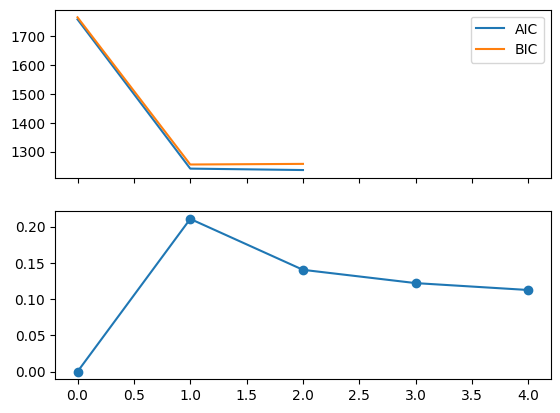

In [497]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(aics, label="AIC")
axs[0].plot(bics, label="BIC")
axs[1].plot(specificity_gain, "-o")
axs[0].legend()

BIC values:  [np.float64(1765.3917900621122), np.float64(1255.0705654927804), np.float64(1257.2269637994743), inf, inf]
AIC values [np.float64(1758.2704268000812), np.float64(1240.8278389687182), np.float64(1235.862874013381), inf, inf]
Best model:  2
(array([0, 1, 2]), array([ 59, 111,  90]))


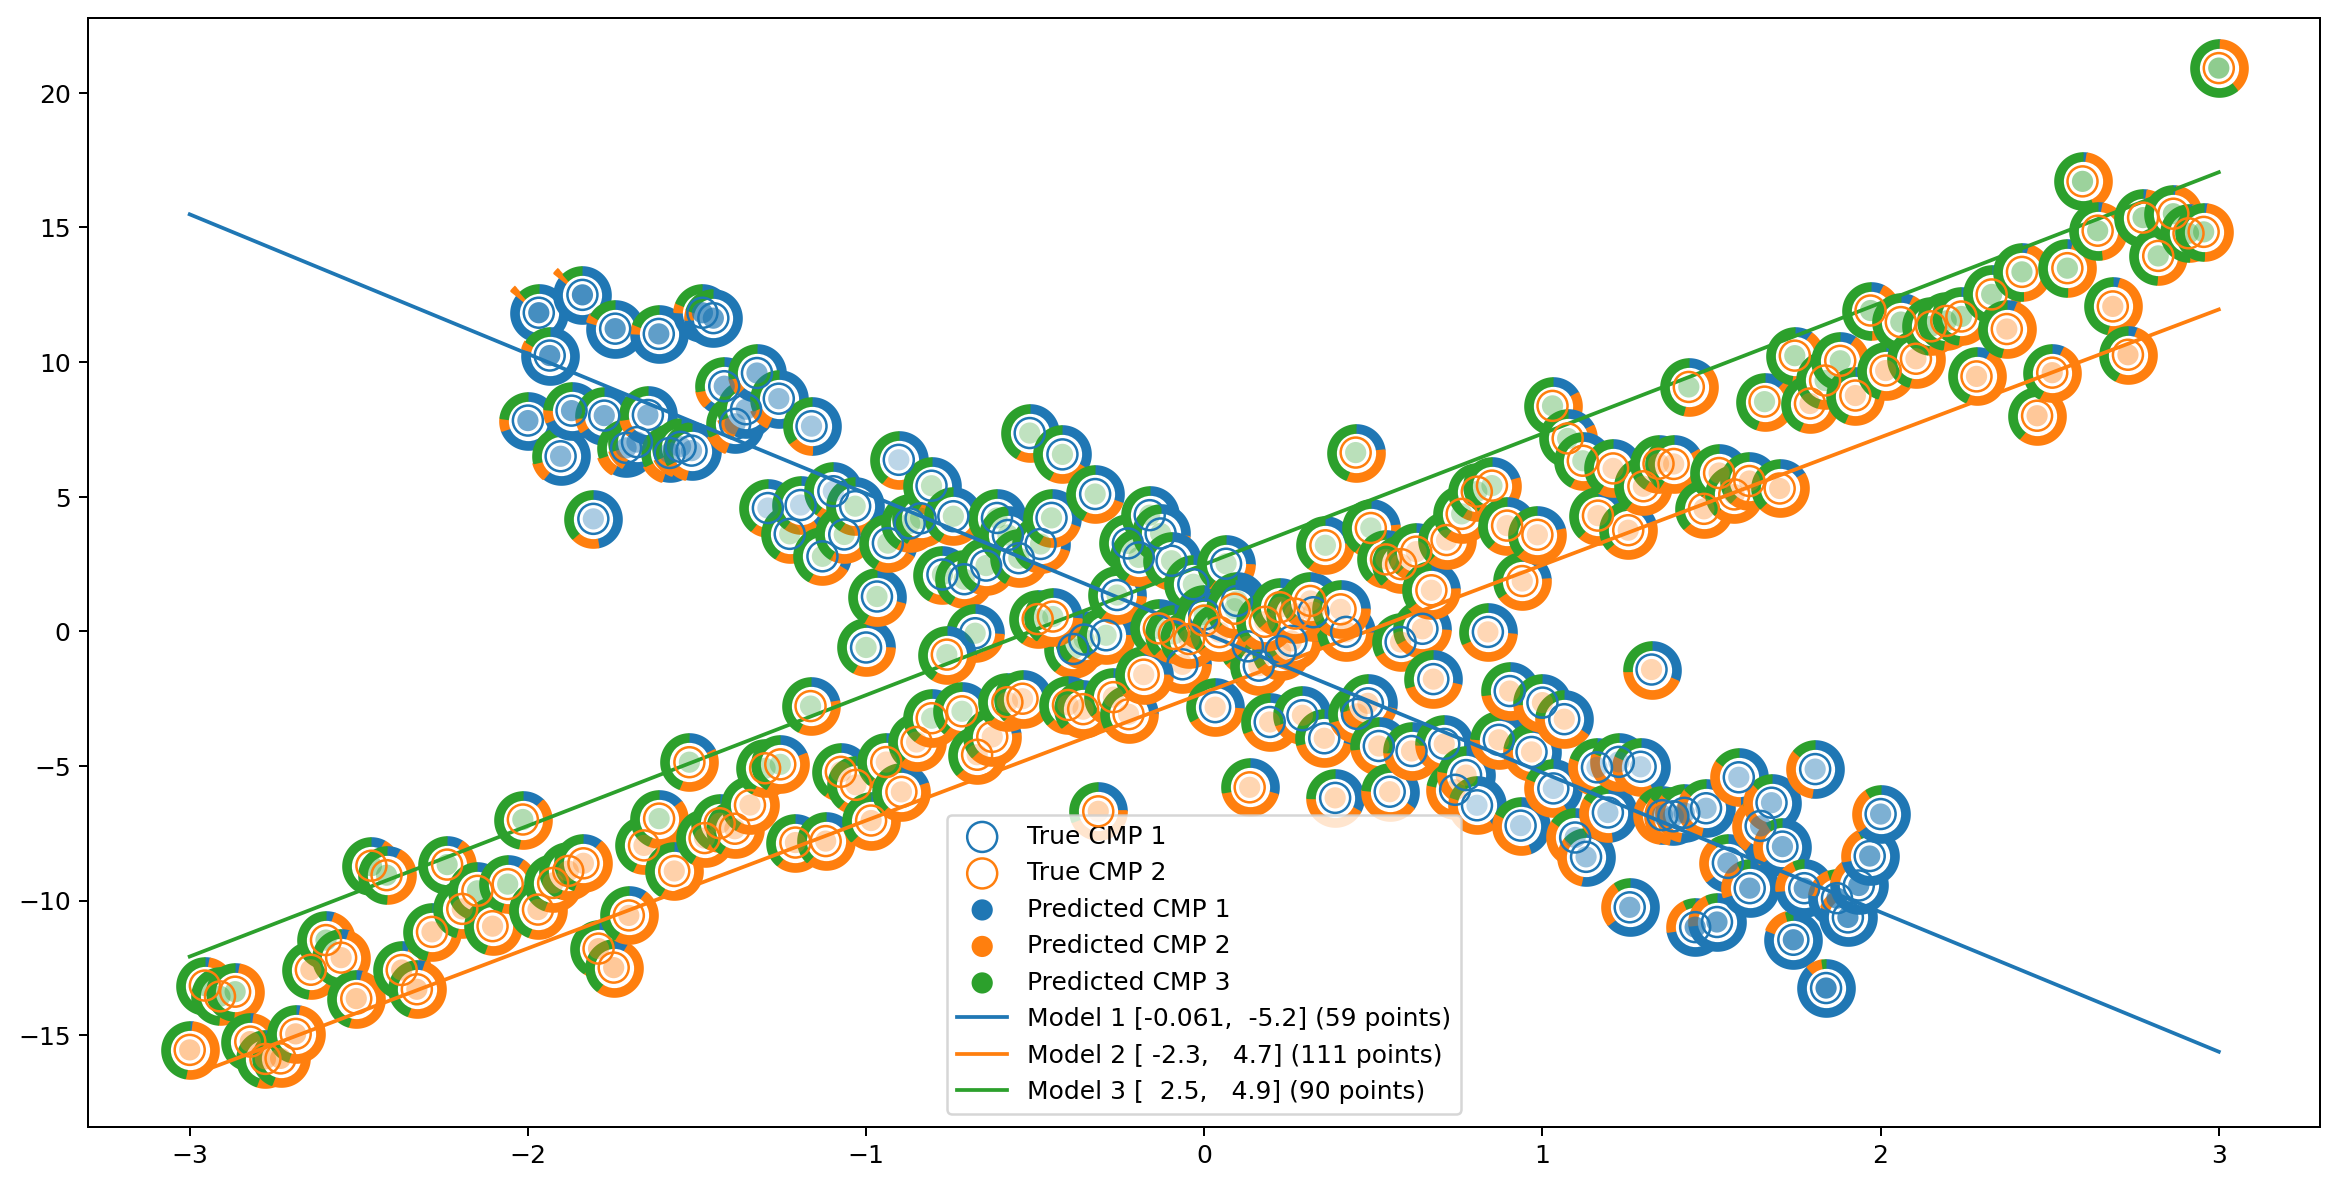

In [498]:
metric = aics
idx_best_model = np.argmin(metric)
print("BIC values: ", bics)
print("AIC values", aics)
print("Best model: ",idx_best_model)
pars = pars_all_models[idx_best_model]

# xsplit, ysplit = split_data(x, y, pars)
idx_membership, p_membership = get_membership(x, y, pars)
b0s = [p[0] for p in pars]
b1s = [p[1] for p in pars]

print(np.unique(idx_membership, return_counts=True))

# RSS = np.sum((y_peak - yfit)**2)
# sigma_sq = RSS / (len(y_peak) - len(popt))
# # log-likelihood
# ll = -0.5 * len(y) * np.log(2 * np.pi * sigma_sq) - RSS / (2 * sigma_sq)
# aic = 2 * len(popt) - 2 * ll
# bic = len(popt) * np.log(len(y_peak))  -  2 * ll

p_cat = p_membership[idx_membership, np.arange(p_membership.shape[1])]

from two_models import plot_ncomp
fig = plot_ncomp((x1, x2), (y1, y2), b0s, b1s, model, idx_membership, p_cat, p_membership)


In [373]:
None in [1,2,3]

False

In [375]:
None in [1,2, [2,34]]

False